Instaliramo pysam za parsiranje VCF fajla

In [1]:
!pip install pysam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 25.5 MB/s eta 0:00:00


Importujemo potrebne biblioteke

In [2]:
import math
import pysam
import warnings
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chisquare
from itertools import groupby
from collections import Counter

warnings.simplefilter("error", RuntimeWarning)

Dovlacimo fajl sa drajva i raspakujemo ga


In [3]:
!cp "/content/drive/Shareddrives/Materijali 2022 2023/6. semestar/Uvod u Bioinformatiku/Projekat 1/Copy of experiment_7.vcf.gz" .
!gzip -d  "Copy of experiment_7.vcf.gz"

Ucitavamo VCF fajl

In [4]:
vcf = pysam.VariantFile('/content/Copy of experiment_7.vcf')

Brojimo semplove

In [5]:
samples = vcf.header.samples
cases = {s for s in vcf.header.samples if s.startswith('case')}
controls = {s for s in vcf.header.samples if s.startswith('control')}

len_samples, len_cases, len_controls = len(samples), len(cases), len(controls)

case - bolesne

control  - zdrave

In [6]:
print('Total={} Case={} Control={}'.format(len_samples, len_cases, len_controls))

Total=200 Case=100 Control=100


In [7]:
variants = list(vcf.fetch())

Prebrojavanje mutacija i tabelarni prikaz broja mutacija po hromozomu

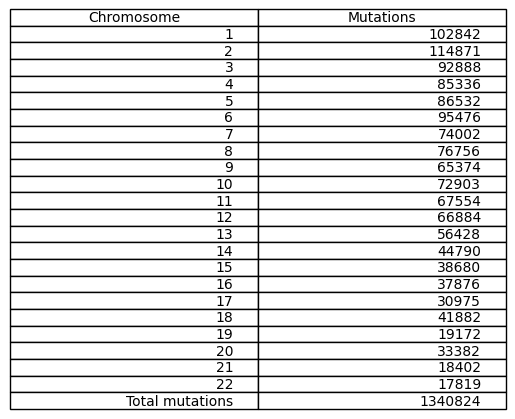

In [8]:

mutacijePoHromozomu = dict()
for variant in vcf.fetch():
    mutacijePoHromozomu[variant.chrom] = 0

for variant in vcf.fetch():
    mutacijePoHromozomu[variant.chrom] += 1


ukupanBrojMutacija = sum(mutacijePoHromozomu.values())

podaciZaTabelu = [[k, v] for k, v in mutacijePoHromozomu.items()]
podaciZaTabelu.append(['Total mutations', ukupanBrojMutacija])


labele = ['Chromosome', 'Mutations']
tabela = plt.table(cellText=podaciZaTabelu, colLabels=labele, loc='center')

plt.axis('off')
plt.show()

In [9]:
def get_genotypes():

  maf_list_zdravi, referentni_list_zdravi, alternativni_list_zdravi, heterozigotni_list_zdravi = [], [], [], []  
  
  maf_list_bolesni, referentni_list_bolesni, alternativni_list_bolesni, heterozigotni_list_bolesni = [], [], [], []
  for variant in vcf.fetch():

      brojReferentnihZdravih = 0
      brojAlternativnihZdravih = 0
      brojHeterozigotaZdravih = 0

      brojReferentnihObolelih = 0
      brojAlternativnihObolelih = 0
      brojHeterozigotaObolelih = 0

      for sample in variant.samples:
        
          data = variant.samples[sample]

          if(len(data['GT']) < 2 or data['GT'][0] == None or data['GT'][1] == None ):
              continue

          if(data['GT'][0] == 0 and data['GT'][1] == 0):
            if(sample.startswith('case')):
              brojReferentnihObolelih += 1
            elif(sample.startswith('control')):
              brojReferentnihZdravih += 1

          if(data['GT'][0] > 0 and data['GT'][1] > 0 and data['GT'][0]==data['GT'][1]):
            if(sample.startswith('case')):
              brojAlternativnihObolelih += 1
            elif(sample.startswith('control')):
              brojAlternativnihZdravih += 1

          if(data['GT'][0] != data['GT'][1]):
            if(sample.startswith('case')):
              brojHeterozigotaObolelih += 1
            elif(sample.startswith('control')):
              brojHeterozigotaZdravih += 1
          
      maf_list_zdravi.append((2 * min(brojReferentnihZdravih, brojAlternativnihZdravih) + brojHeterozigotaZdravih) / (len_samples))
      maf_list_bolesni.append((2 * min(brojReferentnihObolelih, brojAlternativnihObolelih) + brojHeterozigotaObolelih) / (len_samples))
     
      referentni_list_zdravi.append(brojReferentnihZdravih / (len_samples/2))
      referentni_list_bolesni.append(brojReferentnihObolelih / (len_samples/2))

      alternativni_list_zdravi.append(brojAlternativnihZdravih / (len_samples/2))
      alternativni_list_bolesni.append(brojAlternativnihObolelih / (len_samples/2))

      heterozigotni_list_zdravi.append(brojHeterozigotaZdravih / (len_samples/2))
      heterozigotni_list_bolesni.append(brojHeterozigotaObolelih / (len_samples/2))

     
          

  return maf_list_zdravi, maf_list_bolesni, referentni_list_zdravi, referentni_list_bolesni,alternativni_list_zdravi,alternativni_list_bolesni,heterozigotni_list_zdravi,heterozigotni_list_bolesni

In [10]:
mafZ,mafB, refZ, refB, altZ, altB, hetZ, hetB = get_genotypes()


In [11]:
def show_hist(data1, data2, index):
    plt.subplot(1, 4, index)
    plt.hist(data1, bins=25,color= 'orange', label='Zdravi')
    plt.hist(data2, bins=25,color= 'blue', label='Oboleli')
    plt.legend()

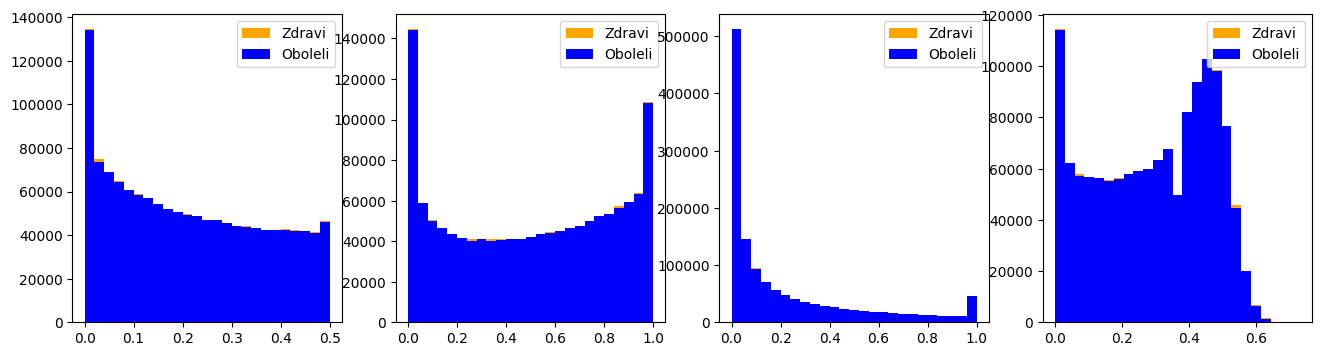

In [12]:
plt.figure(figsize=(16, 4))
show_hist(mafZ, mafB, 1)
show_hist(refZ, refB, 2)
show_hist(altZ, altB, 3)
show_hist(hetZ, hetB, 4)
plt.show()

Hi kvadrat

In [13]:
def run_chi2(v):

    #na osnovu genotipa svakog sempla, kreiramo case_counts gde ce
    #u zavisnnosti od zbira 0, 1 ili 2 biti homRef, homAlt ili heter

  

    case_counts = Counter([sum(v.samples[s]['GT']) for s in cases])
    case_refs = 2 * case_counts[0] + case_counts[1]
    case_alts = 2 * case_counts[2] + case_counts[1]

    control_counts = Counter([sum(v.samples[s]['GT']) for s in controls])
    control_refs = 2 * control_counts[0] + control_counts[1]
    control_alts = 2 * control_counts[2] + control_counts[1]

    total = case_refs + case_alts + control_refs + control_alts




    try:

        #kreiramo kontingencijsku tablicu 2x2
        observed = [case_refs, case_alts, control_refs, control_alts]
        expected = [(case_refs + case_alts) * (case_refs + control_refs) / total,
                    (case_refs + case_alts) * (case_alts + control_alts) / total,
                    (control_refs + control_alts) * (case_refs + control_refs) / total,
                    (control_refs + control_alts) * (case_alts + control_alts) / total]
        return chisquare(observed, expected, ddof=2).pvalue
    except Warning:
        return None

In [14]:
#kreiramo listu torki gde ce svaka torka imati vrednost za hromozom, poziciju i povratnu vrednost hi testa 

chi2_raw = [(v.chrom, v.pos, run_chi2(v)) for v in variants]
chi2 = [x for x in chi2_raw if x[2] is not None]

In [15]:
#kreiramo recnik results gde je kljuc jedinstveni hromozom, 
#a vrednost je lista svih torki koje imaju taj hromozom

results = {k: list(v) for k, v in groupby(chi2, key=lambda x: x[0])}

In [16]:
import pprint

pprint.pprint(results.keys())


dict_keys(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22'])


Racunamo duzinu hromozoma

In [80]:
#duzina hromozoma se moze odrediti na osnovu pozicija varijacija na tom horomozomu. Posto je u VCF sortirano
#po pozicijama, maksimalna pozicija ce predstavljati duzinu hromozoma


#vracamo listu duzina svih hromozoma
def chrom_lengths():
    chrom_groups = groupby(variants, key=lambda v: v.chrom)
    return [max([v.pos for v in g]) for _, g in chrom_groups]

Manhattan plot

In [81]:
def show_manhattan(bonferroni = False):
    lengths = chrom_lengths()


    #raspodeljujemo sirine hromozoma na grafu, gde ce imati ukupan zbir 100
    
    
    widths = [math.ceil(100 * x / sum(lengths)) for x in lengths]

    plt.figure(figsize=(16, 4))

    for i, chrom in enumerate(results):

        #za svaki hromozom smestaju se pozizije varijacija u listu pos, a onda za svaku varijaciju
        #racunamo -log10(p-value) i smestamo u p
        pos = [x[1] for x in results[chrom]]
        p = [-np.log10(x[2]) for x in results[chrom]]

        #definisemo poziciju grafa na matrici i iscrtavamo pozicije
        plt.subplot2grid((1, sum(widths)), (0, sum(widths[:i])), colspan=widths[i])
        plt.scatter(pos, p)
        plt.ylim(0, 15)
        #izvrsavamo Bonferroni korekciju
        plt.axhline(-np.log10(0.01 / ukupanBrojMutacija if bonferroni else 0.01), c='r')
        

    plt.show()
     

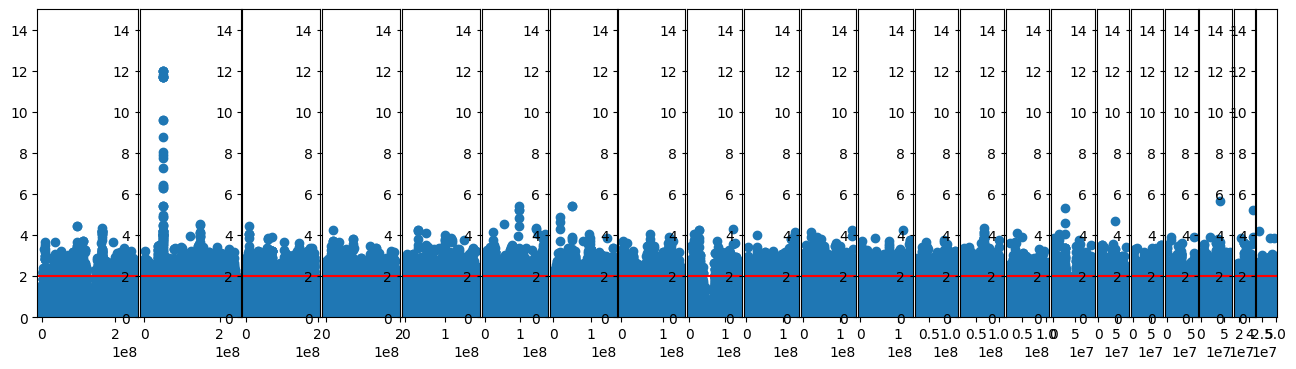

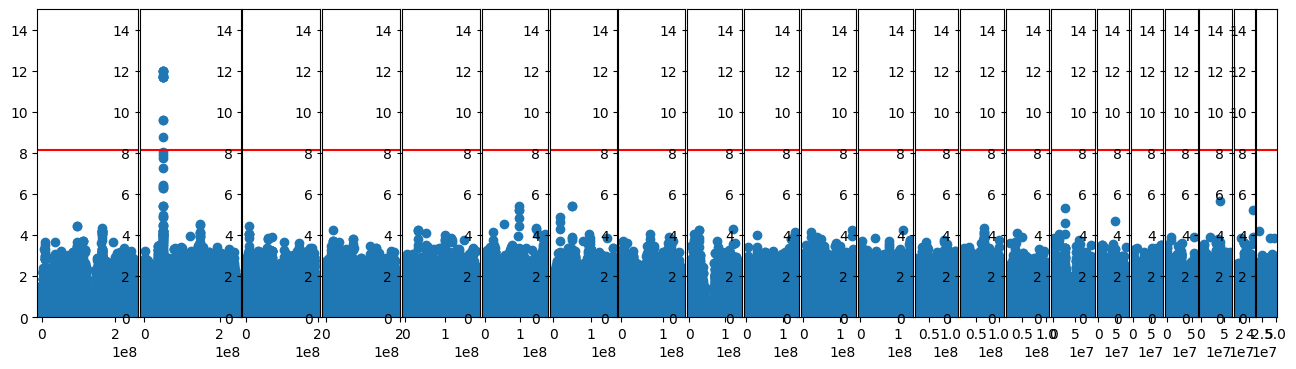

In [82]:

show_manhattan()
show_manhattan(True)

Trazimo podrucja genoma koja sadrze znacajne mutacije

In [83]:
def get_regions():
    regions = []
    
    for i, chrom in enumerate(results):
        pos = [x[1] for x in results[chrom]]
        p = [-np.log10(x[2]) for x in results[chrom]]

        #cuva one p cija je vrednost veca od korekcije za visestruko testiranje
        signif = [x for x in p if x > -math.log10(0.05 / ukupanBrojMutacija)]

        pos_min, pos_max = float('inf'), float('-inf')
    

        # prolazimo kroz sve vrednosti u p i ako se ta vrednost nalazi u signif, dohvatammo  poziciju
        # koja odogovara trenutnom p i azuriramo granice regiona
        for j, x in enumerate(p):
            if x in signif:
                pos_min, pos_max = min(pos_min, pos[j]), max(pos_max, pos[j])

        #ako smo nasli neki region, dodajemo ga u listu recnika koji ce imati kljuceve
        #chr, min i max

        if pos_min != float('inf') and pos_max != float('-inf'):
            regions.append({'chr' : i + 1, 'min' : pos_min, 'max' : pos_max})

    return regions
     

In [84]:
def isinside(v, r):
    return int(v.chrom) == r['chr'] and r['min'] <= v.pos < r['max']

U ovom bloku koda prolazimo kroz sve regije dobijene funkcijom get_regions() i sve mutacije variants, i za svaku mutaciju proveravamo da li se nalazi unutar neke od regija. Ako jeste, mutacija se dodaje u listu signif koja predstavlja statistički značajne mutacije.

In [85]:
regions = get_regions()
signif = []

for r in regions:
    for v in variants:
        if isinside(v, r):
          
            signif.append(v)



In [86]:
def check_hwe(v):
    counts = Counter([sum(s['GT']) for s in v.samples.values() if None not in s['GT']])
    total = sum(counts.values())
    
    p = (2 * counts[0] + counts[1]) / (2 * total)
    q = (2 * counts[2] + counts[1]) / (2 * total)

    try:
        observed = [counts[0], counts[1], counts[2]]
        expected = [p * p * total, 2 * p * q * total, q * q * total]
        return chisquare(observed, expected, ddof=1).pvalue #vraca se p
    except Warning:
        return None

In [87]:
hwe_raw = [check_hwe(v) for v in signif]
hwe = [x > (0.01 / ukupanBrojMutacija) for x in hwe_raw if x is not None]

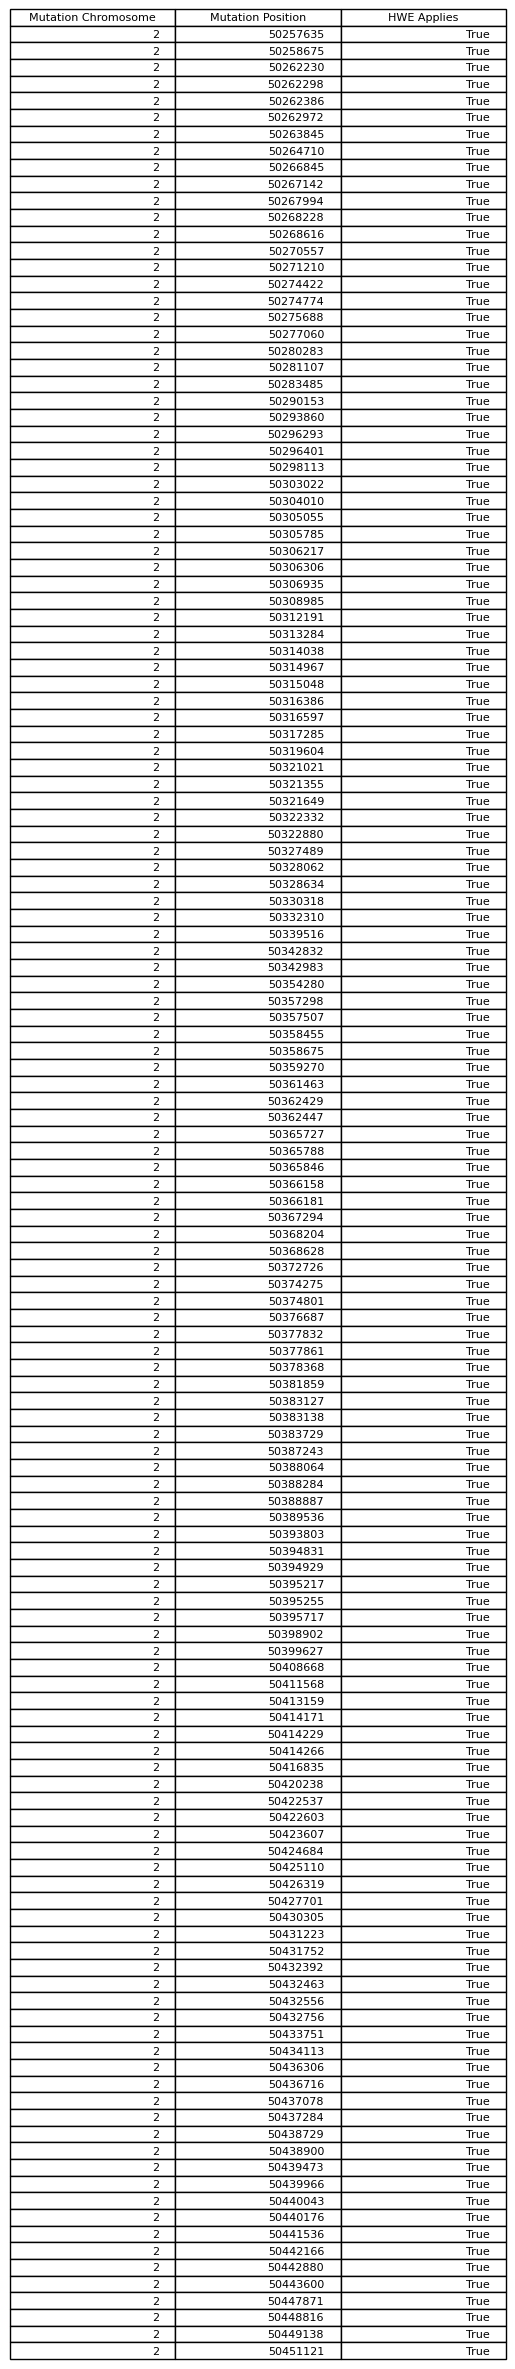

In [88]:

#Funkcija zip spaja elemente iz dve liste signif i hwe po istim indeksima i pravi tuple od njih. 
hwe_data = [[v.chrom, v.pos, h] for (v, h) in zip(signif, hwe)]

hwe_labels = ['Mutation Chromosome', 'Mutation Position', 'HWE Applies']
hwe_table = plt.table(cellText=hwe_data, colLabels=hwe_labels, loc='center')

plt.axis('off')
plt.show()